In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import textract
import PyPDF2
import en_core_web_sm
from spacy.pipeline import EntityRuler
from spacy import displacy
import jsonlines

%matplotlib inline

ModuleNotFoundError: No module named 'textract'

In [ ]:
def extract_text_from_pdf(file):
    '''Opens and reads in a PDF file from path'''
    
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    page_count = fileReader.getNumPages()
    text = [fileReader.getPage(i).extractText() for i in range(page_count)]
    
    return str(text).replace("\\n", "")

def extract_text_from_word(filepath):
    '''Opens and reads in a .doc or .docx file from path'''
    
    txt = textract.process(filepath).decode('utf-8')
    
    return txt.replace('\n', ' ').replace('\t', ' ')


In [ ]:
# Load pre-trained English language model
# nlp = nl_core_news_sm.load()
nlp = spacy.load("en_core_web_sm")

# File Extension. set as 'pdf' or as 'doc(x)'
extension = 'pdf'

In [ ]:
def create_tokenized_texts_list(extension):
    '''Create two lists, one with the names of the candidate and one with the tokenized 
       resume texts extracted from either a .pdf or .doc'''
    resume_texts, resume_names = [], []
    
    # Loop over the contents of the directory containing the resumes, filtering by .pdf or .doc(x)
    for resume in list(filter(lambda x: extension in x, os.listdir(PROJECT_DIR + '/CV'))):
        if extension == 'pdf':
            # Read in every resume with pdf extension in the directory
            resume_texts.append(nlp(extract_text_from_pdf(PROJECT_DIR + '/CV/' + resume)))
        elif 'doc' in extension:
            # Read in every resume with .doc or .docx extension in the directory
            resume_texts.append(nlp(extract_text_from_word(PROJECT_DIR + '/CV/' + resume)))
            
        resume_names.append(resume.split('_')[0].capitalize())
        
    return resume_texts, resume_names

In [2]:
#resume should have skill column, experience column, 
# resumedata = pd.read_csv("resume.csv")
# joblistings = pd.read_csv("jobs.csv")
# test_coverletters = pd.read_csv("coverletter.csv")

In [3]:
# filter job listings and test cover letter csvs by using the column 'id' representing any 
# column of the job listings or coverletter data to index the ['foo','bar'] list, representing
# a column of the resume data (words extracted from pdf file in one of the classification columns
# labeled something like skills or experience)
# joblistings[joblistings['id'].isin(['foo','bar'])]

In [4]:
# sns.pairplot(data, hue='Class')

In [5]:
default_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

In [6]:
embedded_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammar,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammar,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

In [7]:
def generate_valid_string(grammar):
    state = 0
    output = []
    while state is not None:
        char, state = grammar[state][np.random.randint(len(grammar[state]))]
        if isinstance(char, list):  # embedded reber
            char = generate_valid_string(char)
        output.append(char)
    return "".join(output)

In [8]:
def generate_corrupted_string(grammar, chars='BTSXPVE'):
    '''Substitute one character to violate the grammar'''
    good_string = generate_valid_string(grammar)
    idx = np.random.randint(len(good_string))
    good_char = good_string[idx]
    bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
    return good_string[:idx]+bad_char+good_string[idx+1:]

In [9]:
chars='BTSXPVE'
chars_dict = {a:i for i,a in enumerate(chars)}
chars_dict

{'B': 0, 'T': 1, 'S': 2, 'X': 3, 'P': 4, 'V': 5, 'E': 6}

In [10]:
def str2onehot(string, num_steps=12, chars_dict=chars_dict):
    res = np.zeros((num_steps, len(chars_dict)))
    for i in range(min(len(string), num_steps)):
        c = string[i]
        res[i][chars_dict[c]] = 1
    return res

In [11]:
def generate_data(data_size=10000, grammar=embedded_reber_grammar, num_steps=None):
    good = [generate_valid_string(grammar) for _ in range(data_size//2)]
    bad = [generate_corrupted_string(grammar) for _ in range(data_size//2)]
    all_strings = good+bad
    if num_steps is None:
        num_steps = max([len(s) for s in all_strings])
    X = np.array([str2onehot(s) for s in all_strings])
    l = np.array([len(s) for s in all_strings])
    y = np.concatenate((np.ones(len(good)), np.zeros((len(bad))))).reshape(-1, 1)
    idx = np.random.permutation(data_size)
    return X[idx], l[idx], y[idx]

In [12]:
np.random.seed(42)
X_train, seq_lens_train, y_train = generate_data(10000)
X_val, seq_lens_val, y_val = generate_data(5000)
X_train.shape, X_val.shape

((10000, 12, 7), (5000, 12, 7))

In [13]:
x = layers.Input(shape=(12, 7)) # we define our input's shape
# first we define our RNN cells to use in the RNN model
# let's keep the model simple ...
cell = layers.SimpleRNNCell(4, activation='tanh')  # ... by just using 4 units (like 4 units in hidden layers)
rnn = layers.RNN(cell)
rnn_output = rnn(x)

2022-07-11 20:27:59.922739: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-11 20:27:59.922804: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (absconditus-82b1): /proc/driver/nvidia/version does not exist
2022-07-11 20:27:59.924205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
output = layers.Dense(units=1, activation='sigmoid')(rnn_output)


In [15]:
# let's compile the model
model = keras.Model(inputs=x, outputs=output)
# loss is binary cropss entropy since this is a binary classification task
# and evaluation metric as f1
model.compile(loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 7)]           0         
                                                                 
 rnn (RNN)                   (None, 4)                 48        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [16]:
# we train the model for 100 epochs
# verbose level 2 displays more info while trianing
H = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_val, y_val))

Epoch 1/100
313/313 - 2s - loss: 0.7067 - accuracy: 0.4893 - val_loss: 0.6939 - val_accuracy: 0.5162 - 2s/epoch - 6ms/step
Epoch 2/100
313/313 - 1s - loss: 0.6931 - accuracy: 0.5204 - val_loss: 0.6893 - val_accuracy: 0.5308 - 933ms/epoch - 3ms/step
Epoch 3/100
313/313 - 1s - loss: 0.6865 - accuracy: 0.5644 - val_loss: 0.6784 - val_accuracy: 0.5916 - 889ms/epoch - 3ms/step
Epoch 4/100
313/313 - 1s - loss: 0.6528 - accuracy: 0.6361 - val_loss: 0.6217 - val_accuracy: 0.6560 - 933ms/epoch - 3ms/step
Epoch 5/100
313/313 - 1s - loss: 0.5975 - accuracy: 0.6911 - val_loss: 0.5750 - val_accuracy: 0.7568 - 991ms/epoch - 3ms/step
Epoch 6/100
313/313 - 1s - loss: 0.5637 - accuracy: 0.7690 - val_loss: 0.5456 - val_accuracy: 0.7880 - 991ms/epoch - 3ms/step
Epoch 7/100
313/313 - 1s - loss: 0.5412 - accuracy: 0.7825 - val_loss: 0.5274 - val_accuracy: 0.7900 - 990ms/epoch - 3ms/step
Epoch 8/100
313/313 - 1s - loss: 0.5244 - accuracy: 0.7871 - val_loss: 0.5127 - val_accuracy: 0.8008 - 967ms/epoch - 3ms/

Epoch 66/100
313/313 - 1s - loss: 0.2667 - accuracy: 0.8956 - val_loss: 0.2695 - val_accuracy: 0.9008 - 908ms/epoch - 3ms/step
Epoch 67/100
313/313 - 1s - loss: 0.2666 - accuracy: 0.8976 - val_loss: 0.2529 - val_accuracy: 0.9048 - 879ms/epoch - 3ms/step
Epoch 68/100
313/313 - 1s - loss: 0.2649 - accuracy: 0.8966 - val_loss: 0.2536 - val_accuracy: 0.9056 - 927ms/epoch - 3ms/step
Epoch 69/100
313/313 - 1s - loss: 0.2637 - accuracy: 0.8962 - val_loss: 0.2523 - val_accuracy: 0.9034 - 880ms/epoch - 3ms/step
Epoch 70/100
313/313 - 1s - loss: 0.2632 - accuracy: 0.8947 - val_loss: 0.2494 - val_accuracy: 0.9078 - 897ms/epoch - 3ms/step
Epoch 71/100
313/313 - 1s - loss: 0.2619 - accuracy: 0.8999 - val_loss: 0.2798 - val_accuracy: 0.8784 - 961ms/epoch - 3ms/step
Epoch 72/100
313/313 - 1s - loss: 0.2618 - accuracy: 0.8991 - val_loss: 0.2597 - val_accuracy: 0.9054 - 979ms/epoch - 3ms/step
Epoch 73/100
313/313 - 1s - loss: 0.2590 - accuracy: 0.8954 - val_loss: 0.2555 - val_accuracy: 0.9090 - 1s/epoc

In [17]:
def plot_results(H):
    results = pd.DataFrame({"Train Loss": H.history['loss'], "Validation Loss": H.history['val_loss'],
              "Train Accuracy": H.history['accuracy'], "Validation Accuracy": H.history['val_accuracy']
             })
    fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
    results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
    results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    plt.show()

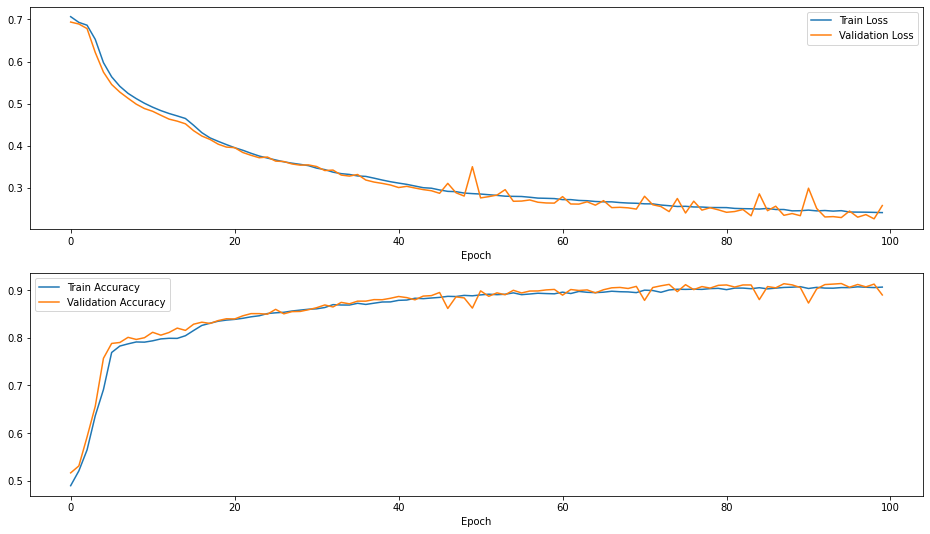

In [18]:
plot_results(H)

Never Train two models on the same kernel session. we already trained the reber grammar one, so it's necessary to restart the kernel

In [19]:
pip install -q tensorflow_datasets

You should consider upgrading via the '/home/absconditus/Documents/Github/Python Projects/jupyter/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow_datasets as tfds


/home/absconditus/Documents/Github/Python Projects/jupyter/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [22]:
train = train_dataset.take(4000)
test = test_dataset.take(1000)

In [23]:
# to shuffle the data ...
BUFFER_SIZE = 4000 # we will put all the data into this big buffer, and sample randomly from the buffer
BATCH_SIZE = 128  # we will read 128 reviews at a time

train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [24]:
train = train.prefetch(BUFFER_SIZE)
test = test.prefetch(BUFFER_SIZE)

In [25]:
VOCAB_SIZE=1000 # assuming our vocabulary is just 1000 words

encoder = layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(train.map(lambda text, label: text)) # we just encode the text, not the labels

2022-07-11 20:29:38.466482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
# here are the first 20 words in our 1000-word vocabulary
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'i', 'it',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'but', 'movie'],
      dtype='<U14')

In [27]:
example, label = list(train.take(1))[0] # that's one batch
len(example)

2022-07-11 20:29:38.985270: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


128

In [28]:
example[0].numpy()

b"While I would say I enjoy the show, I expected something completely different from when I first saw 'What I like about you' I expected to find something along the lines of 'All That' (I am not sure if it is going on anymore) but I have to say I do like the show and while i don't classify it as a breakthrough show, it is very charming and I do like the chemistry between the characters as well (including the supporting cast)<br /><br />I would definitely say that it is great to see Wesley Jonathan back on the screen because I really loved him in City Guy. I had also seen the woman who plays Valerie's friend in Popular and while I think that was an okay show, I do not really like her character in this show because she's just not my cup of tea but she rounds it out pretty well"

In [29]:
encoded_example = encoder(example[:1]).numpy()
encoded_example

array([[129,   9,  60, 128,   9, 334,   2, 120,   9, 834, 141, 348, 283,
         38,  53,   9,  74, 208,  48,   9,  39,  45,  25,   9, 834,   6,
        156, 141, 338,   2, 466,   5,  32,  12,   9, 214,  22, 233,  43,
         10,   7, 161,  21,   1,  18,   9,  26,   6, 128,   9,  82,  39,
          2, 120,   3, 129,   9,  89,   1,  10,  15,   4,   1, 120,  10,
          7,  52,   1,   3,   9,  82,  39,   2,   1, 210,   2, 103,  15,
         84, 515,   2, 648,   1,  13,   9,  60, 411, 128,  12,  10,   7,
         80,   6,  67,   1,   1, 140,  21,   2, 312,  81,   9,  62, 422,
         90,   8, 501, 231,   9,  63,  77, 111,   2, 240,  37, 287,   1,
        433,   8, 986,   3, 129,   9, 102,  12,  14,  35, 909, 120,   9,
         82,  22,  62,  39,  40, 109,   8,  11, 120,  81, 419,  41,  22,
         54,   1,   5,   1,  18,  56,   1,  10,  44, 173,  84]])

In [30]:
model = tf.keras.Sequential([
    encoder, # the encoder
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(layers.LSTM(64)), # making LSTM bidirectional
    tf.keras.layers.Dense(32, activation='relu'), # FC layer for the classification part
    tf.keras.layers.Dense(1) # final FC layer

])

In [31]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[3.0102441e-05]


In [32]:
# we will use binary cross entropy again because this is a binary classification task (positive or negative)
# we also did not apply a sigmoid activation function at the last FC layer, so we specify that the 
# are calculating the cross entropy from logits
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # adam optimizer is more efficient (not always the most accurate though)
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 134,209
Trainable params: 134,209
Non-trai

In [34]:
H2 = model.fit(train, epochs=25,
                    validation_data=test)

Epoch 1/25


2022-07-11 20:29:50.315399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4967

2022-07-11 20:30:25.454266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 45s 1s/step - loss: 0.6931 - accuracy: 0.4967 - val_loss: 0.6929 - val_accuracy: 0.5030
Epoch 2/25


2022-07-11 20:30:28.090437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.4967

2022-07-11 20:30:58.218446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 33s 1s/step - loss: 0.6925 - accuracy: 0.4967 - val_loss: 0.6926 - val_accuracy: 0.5030
Epoch 3/25


2022-07-11 20:31:00.802621: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.4967

2022-07-11 20:31:32.692173: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 35s 1s/step - loss: 0.6917 - accuracy: 0.4967 - val_loss: 0.6920 - val_accuracy: 0.5030
Epoch 4/25


2022-07-11 20:31:35.415868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.4967

2022-07-11 20:32:08.311491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 36s 1s/step - loss: 0.6904 - accuracy: 0.4967 - val_loss: 0.6910 - val_accuracy: 0.5030
Epoch 5/25


2022-07-11 20:32:11.052151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.4967

2022-07-11 20:32:43.731265: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 35s 1s/step - loss: 0.6881 - accuracy: 0.4967 - val_loss: 0.6890 - val_accuracy: 0.5030
Epoch 6/25


2022-07-11 20:32:46.343353: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.4967

2022-07-11 20:33:17.200397: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 33s 989ms/step - loss: 0.6820 - accuracy: 0.4967 - val_loss: 0.6818 - val_accuracy: 0.5090
Epoch 7/25


2022-07-11 20:33:19.807345: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.5505

2022-07-11 20:33:51.206500: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 34s 1s/step - loss: 0.6578 - accuracy: 0.5505 - val_loss: 0.6797 - val_accuracy: 0.5580
Epoch 8/25


2022-07-11 20:33:53.737843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6308

2022-07-11 20:34:23.644701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 33s 1s/step - loss: 0.6032 - accuracy: 0.6308 - val_loss: 0.6358 - val_accuracy: 0.6820
Epoch 9/25


2022-07-11 20:34:26.279445: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.6867

2022-07-11 20:34:55.698382: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


32/32 [==============================] - 32s 992ms/step - loss: 0.5952 - accuracy: 0.6867 - val_loss: 0.6088 - val_accuracy: 0.6290
Epoch 10/25


2022-07-11 20:34:58.284499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


16/32 [==============>...............] - ETA: 15s - loss: 0.5539 - accuracy: 0.6963

KeyboardInterrupt: 

In [ ]:
plot_results(H2)

In [ ]:
#always pass a list for predict
model.predict(["this one probably won't work."])

In [ ]:
predict = model.predict(["able was I ere I saw Elba."])

In [ ]:
print(predict)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
sentences = [
             'I love my dog',
             'I love my cat'
]

In [ ]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

In [14]:
sentences = [
             'I love my dog',
             'I love my cat',
             'You love my dog!',
             'Do you think my dog is amazing?'
]
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [15]:
sequences = tokenizer.texts_to_sequences(sentences)

print(word_index)
print(sequences)

{'my': 1, 'love': 2, 'dog': 3, 'i': 4, 'you': 5, 'cat': 6, 'do': 7, 'think': 8, 'is': 9, 'amazing': 10}
[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]


In [ ]:
tokenizer = Tokenizer(num_words = 100, oov_token="<00V>")

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
padded = pad_sequences(sequences)

In [ ]:
print(padded)

In [ ]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [ ]:
train_data, test_data = imdb['train'], imdb['test']


In [ ]:
import numpy as np

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

In [ ]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [4]:
def readFile(dirname):
    wordset = []
    with os.scandir(dirname) as entries:
        for entry in entries:
            fileObj = open(entry, "r") #opens the file in read mode
            words = fileObj.read().splitlines() #puts the file into an array
            newwords=[i for i in words if i.find("=")== -1]
            wordset.append(newwords);
            fileObj.close()
    return wordset

In [19]:
datum = readFile("training_data")
print(datum)

[['Beginning - manual input:', 'Dear Ms. Mustermann, with this letter and attached resume, I would like to express my sincere interest in the vacancy for ‘UI/UX Designer’."', '', 'As an accomplished and customer-centric professional with more than 13 years of experience designing and implementing user-friendly interface solutions to efficiently and successfully meet the needs of both end users and designers, I feel confident in my ability to significantly contribute to the success of your company.', '', 'My experience includes designing and implementing a broad range of user-friendly design solutions to drive market share, performance, and customer engagement. With my professional achievements, combined with my technical and customer service capabilities, I am confident that my talents and abilities will significantly benefit Yougalers.', '', 'The following achievements demonstrate my qualification for this position:', '', ' Designing user interfaces to ensure seamless interface soluti

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 2000)

In [2]:
pip install -U spacy

     |████████████████████████████████| 6.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 457 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 181 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 822 kB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 10.2 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 3.9 MB/s  eta 0:00:01
You should consider upgrading via the '/home/absconditus/Documents/Github/Python Projects/jupyter/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install -U spacy
# python -m spacy download en_core_web_sm
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)